In [58]:
import os
import numpy as np
import pandas as pd
import array
import mmap
import matplotlib.pyplot as plt
import seaborn as sns
sep = '/'
import math
import scipy.linalg as LA

- Load raw data

In [59]:
path = "/Users/sharplab/tran/cat/Tran/2018-05-03_02 (done)/2018-05-03_02.dat"
kilosort_folder = '/Users/sharplab/tran/cat/Tran'
recording = '2018-05-03_02 (done)'
fig_path = "/Users/sharplab/tran/cat/Tran/2018-05-03_02 (done)/figures"
data = np.memmap(path, shape =(327354368,32), dtype = np.int16)


def load_kilosort_arrays(recording):
    spike_clusters = np.load('spike_clusters.npy')
    spike_times = np.load('spike_times.npy')
    cluster_groups = pd.read_csv('cluster_groups.csv', sep='\t')
    try:  # check data quality
        assert np.shape(spike_times.flatten()) == np.shape(spike_clusters)
    except AssertionError:
        AssertionError('Array lengths do not match in recording {}'.format(
            recording))
    return spike_clusters, spike_times, cluster_groups

def load_data(recording, kilosort_folder, verbose, sep):
    if verbose:
        print('\nLoading Data:\t{}\n'.format(recording))
        os.chdir(sep.join([kilosort_folder, recording]))
        spike_clusters, spike_times, cluster_groups = load_kilosort_arrays(
            recording)
    return spike_clusters, spike_times, cluster_groups

def get_good_cluster_numbers(cluster_groups_df):
    good_clusters_df = cluster_groups_df.loc[cluster_groups_df['group'] == 'good', :]
    return good_clusters_df['cluster_id'].values

spike_clusters, spike_times, cluster_groups = load_data(recording=recording,
                                                        kilosort_folder=kilosort_folder,
                                                        verbose=True,
                                                        sep=sep)

good_cluster_numbers = get_good_cluster_numbers(cluster_groups)


Loading Data:	2018-05-03_02 (done)



In [64]:
good_cluster_numbers[26]

109

Parameters for analysis

In [65]:
cluster_to_plot = good_cluster_numbers[26]
num_spikes_for_averaging = 1000
num_channels = 32
num_samples_per_waveform = 60
waveform_window = np.arange(int(-num_samples_per_waveform/2),int(num_samples_per_waveform/2))
fig_to_save = [fig_path,"cluster"+ str(cluster_to_plot)+'png']

Indexing the spikes for analysis

In [66]:
df = pd.DataFrame({'cluster':spike_clusters.flatten(), 'spike_times':spike_times.flatten()})
df = df.loc[df['cluster'].isin(good_cluster_numbers)]
extracted_spikes = df[df['cluster']==cluster_to_plot]['spike_times'][0:num_spikes_for_averaging]

Generating the mean waveform

In [67]:
threeD_matrix = np.zeros((num_spikes_for_averaging, num_samples_per_waveform, num_channels)) # Create the 3D matrix witht he shape (1000,60,32)

for spike in np.arange(0,num_spikes_for_averaging):
    start_index = int(extracted_spikes.iloc[spike]+waveform_window[0])  #  start of waveform in raw data
    end_index = int((extracted_spikes.iloc[spike]+waveform_window[-1])+1)  #  end of waveform in raw data
    
    waveform = data[start_index:end_index, 0:num_channels] #  extract waveform from raw data
    threeD_matrix[spike, :, :] = waveform[:,:]  #  add extracted waveform to 3d matrix

mean_waveform = np.mean(threeD_matrix, axis=0)

Index out the largest waveform

In [68]:
waveform_per_channel_df = pd.DataFrame(mean_waveform)
maxes = waveform_per_channel_df.apply(np.min, axis=0)
lab = maxes.idxmin()


Plot it

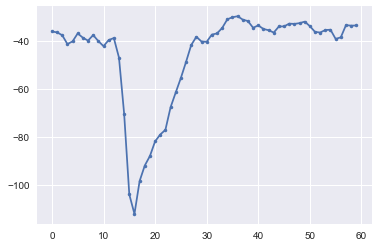

In [69]:
sns.set()
correct_chan = waveform_per_channel_df.loc[:, lab]
plt.plot(correct_chan, linestyle=None, marker='.')
plt.show()

In [70]:
correct_chan = correct_chan.reset_index()
correct_chan.columns = ['figure', 'y_values']
correct_chan.set_index('figure', inplace=True)
new_list = [correct_chan['y_values'][trend_values] for trend_values in np.arange(0,59,1) if (correct_chan['y_values'][trend_values]<correct_chan['y_values'][trend_values+1])]
correct_chan['trend'] = np.where(correct_chan['y_values'].isin(new_list), 'increase', 'decrease')

In [71]:
import numpy as np
import pylab

def baseline_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                return i-1
            else:
                pass
            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])


In [84]:
def baseline_algo_for_down_up(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                pass
            else:
                return i-1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

# Splitting data into different time periods for analysis

In [73]:
min_value = correct_chan['y_values'].min()
max_value = correct_chan['y_values'].max()
min_peak_time = correct_chan['y_values'].idxmin()
max_peak_time = correct_chan['y_values'].idxmax()

small_peak_value = correct_chan[:min_peak_time].max()[0]
small_peak_time = correct_chan[:min_peak_time]['y_values'].idxmax()

''' 
Split the data into 3 periods for analysis
1) from start to the max (baseline value is in this period)
2) from max to min (can just index max and min peak time directly)
3) from min to end (return of baseline value is in this period)

In case that there's no min peak, the data is split into
1) from start to max
2) from max to end
'''

from_start_to_max = np.arange(1, max_peak_time+1, 1)
from_start_to_min = np.arange(1, correct_chan['y_values'].idxmin()+1, 1)
from_min_to_end = np.arange(min_peak_time, 59, 1) 
counter_when_no_min = np.arange(max_peak_time, 59, 1)
counter_for_special = np.arange(1, small_peak_time, 1)

# Functions for standard waveforms


In [74]:
def find_baseline(max_peak_time, from_start_to_max, correct_chan): 
    baseline = []
    ''' 
    Baseline is defined as the first point where there's a significant y-value increase. 
    
    aka. the difference in y values between x+1 and x is twice that of x and x-1. x is the data point
    '''
    
    for time_point in from_start_to_max:
        if np.absolute(correct_chan.loc[time_point][0]-correct_chan.loc[time_point-1][0])*3>np.absolute(correct_chan.loc[time_point+1][0]-correct_chan.loc[time_point][0])>np.absolute(correct_chan.loc[time_point][0]-correct_chan.loc[time_point-1][0]): 
            baseline.append(time_point)
        else:
            pass
    return baseline


def find_return_point(min_peak_time, from_min_to_end, correct_chan):
    return_point = []
    baseline_value = correct_chan.loc[find_baseline(max_peak_time, from_start_to_max, correct_chan)[-1]][0]
    
    '''
    return point is the first value just before the value becoming higher than baseline value
    '''
    for return_time_point in from_min_to_end:
        if correct_chan.loc[return_time_point+1][0] > baseline_value or correct_chan.loc[return_time_point+1]['trend']=='decrease':
            return return_time_point
        else:
            pass

def plot_waveform(fig_to_save, correct_chan, baseline, min_peak_time, baseline_value, return_point):
    plt.plot(correct_chan['y_values'], linestyle=None, marker='.')
    plt.plot(np.ones(5)*baseline, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*return_point, np.linspace(-400, 650, 5), 'k')
    
    
    '''
    Find the estimation of the return to baseline value if the return point is not very accurate due to not having enough data points
    
    y=ax+b
    
    where y is our y value x is time
    
    we can find the values of a and b by solving the simultaneous equation using the x and y values of the two data points above and below:

    y1 = ax1 + b 
    y2 = ax2 + b 

    => a = (x1-x2)/(y1-y2)
   
       b = y1-ax1
           a = (correct_chan.loc[return_point][0]-correct_chan.loc[return_point+1][0])/(return_point-(return_point+1))
    b = correct_chan.loc[return_point][0]-a*(return_point)

    estimated_return_time = (baseline_value-b)/a
    plt.plot(np.ones(5)*estimated_return_time, np.linspace(-400, 650, 5), 'r')
    '''
    
    


    plt.savefig(sep.join(fig_to_save))

    


# Functions for waveforms without trough

In [75]:

def find_return_point_when_no_min(max_peak_time, counter_when_no_min, correct_chan):
    return_point_when_no_min = []
    base_value = correct_chan.loc[find_baseline(max_peak_time, from_start_to_max, correct_chan)[-1]][0]
    
    '''
    The time point just before the y-value becoming lower than baseline value (from the max peak)
    '''
  
    for no_min_return_point in counter_when_no_min:
        if correct_chan.loc[no_min_return_point+1][0] < baseline_value:
            return no_min_return_point
        else:
            pass

def plot_waveform_when_no_min(fig_to_save, baseline, correct_chan, baseline_value, no_min_return_point):
    plt.plot(correct_chan['y_values'], linestyle=None, marker='.')
    plt.plot(np.ones(5)*baseline, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*no_min_return_point, np.linspace(-400, 650, 5), 'k')
    
    a = (correct_chan.loc[no_min_return_point][0]-correct_chan.loc[no_min_return_point+1][0])/(no_min_return_point-(no_min_return_point+1))
    b = correct_chan.loc[no_min_return_point][0]-a*(no_min_return_point)

    estimated_return_time = (baseline_value-b)/a
    plt.plot(np.ones(5)*estimated_return_time, np.linspace(-400, 650, 5), 'r')
    plt.savefig(sep.join(fig_to_save))

# Functions for down_up waveforms

In [76]:
def find_baseline_for_down_up(min_peak_time, from_start_to_min, correct_chan): #Method to find baseline is standardised for all types of waveforms 
    baseline_for_down_up = []
    
    ''' 
    Same as standard baseline except the value is the first point where there's a significant y-value DECREASE
    '''
    
    for time_point_for_down_up in from_start_to_min:
        if np.absolute(correct_chan.loc[time_point_for_down_up][0]-correct_chan.loc[time_point_for_down_up-1][0])*3>np.absolute(correct_chan.loc[time_point_for_down_up+1][0])-np.absolute(correct_chan.loc[time_point_for_down_up][0])>np.absolute(correct_chan.loc[time_point_for_down_up][0]-correct_chan.loc[time_point_for_down_up-1][0]): 
            baseline_for_down_up.append(time_point_for_down_up)
        else:
            pass
    return baseline_for_down_up

def find_return_point_for_down_up(min_peak_time, from_min_to_end, correct_chan):
    baseline_value = correct_chan.loc[find_baseline_for_down_up(min_peak_time, from_start_to_min, correct_chan)[-1]][0]
    
    '''
    The time point just before the y-value becoming higher than baseline value (from the min peak)
    '''
    for return_point_for_down_up in from_min_to_end:
        if correct_chan.loc[return_point_for_down_up+1][0] > baseline_value or correct_chan.loc[return_point_for_down_up+1]['trend']=='decrease':
            return return_point_for_down_up
        else:
            pass
        
def plot_waveform_for_down_up(fig_to_save, baseline_for_down_up, correct_chan, baseline_value_for_down_up, return_point_for_down_up):
    plt.plot(correct_chan['y_values'], linestyle=None, marker='.')
    plt.plot(np.ones(5)*baseline_for_down_up, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*return_point_for_down_up, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')
    
    a = (correct_chan.loc[return_point_for_down_up][0]-correct_chan.loc[return_point_for_down_up+1][0])/(return_point_for_down_up-(return_point_for_down_up+1))
    b = correct_chan.loc[return_point_for_down_up][0]-a*(return_point_for_down_up)

    estimated_return_time = (baseline_value_for_down_up-b)/a
    plt.plot(np.ones(5)*estimated_return_time, np.linspace(-400, 650, 5), 'r')
    plt.savefig(sep.join(fig_to_save))

# Functions for special up-down-up

In [77]:
def find_special_baseline(small_peak_time, counter_for_special, correct_chan): #Method to find baseline is standardised for all types of waveforms 
    special_baseline = []

    ''' 
    The value is the first point where there's a significant y-value INCREASE before the small max peak
    '''
    for special_time_point in counter_for_special:
        if np.absolute(correct_chan.loc[special_time_point][0]-correct_chan.loc[special_time_point-1][0])*3>np.absolute(correct_chan.loc[special_time_point+1][0]-correct_chan.loc[special_time_point][0])>np.absolute(correct_chan.loc[special_time_point][0]-correct_chan.loc[special_time_point-1][0]): 
            special_baseline.append(special_time_point)
        else:
            pass
    return special_baseline

def find_special_return_point(small_peak_time, from_min_to_end, correct_chan):
    special_baseline_value = correct_chan.loc[find_baseline_for_down_up(small_peak_time, from_start_to_min, correct_chan)[-1]][0]
    
    '''
    return point is the first value from the min peak, just before the value higher than baseline value
    '''
    for special_return_point in from_min_to_end:
        if correct_chan.loc[special_return_point+1][0] > special_baseline_value or correct_chan.loc[special_return_point+1]['trend']=='decrease':
            return special_return_point
        else:
            pass
        
def plot_special_waveform(fig_to_save, special_baseline, correct_chan, special_baseline_value, special_return_point):
    plt.plot(correct_chan['y_values'], linestyle=None, marker='.')
    plt.plot(np.ones(5)*special_baseline, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*special_return_point, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')
    
    a = (correct_chan.loc[special_return_point][0]-correct_chan.loc[special_return_point+1][0])/(special_return_point-(special_return_point+1))
    b = correct_chan.loc[special_return_point][0]-a*(special_return_point)

    estimated_return_time = (special_baseline_value-b)/a
    plt.plot(np.ones(5)*estimated_return_time, np.linspace(-400, 650, 5), 'r')
    plt.savefig(sep.join(fig_to_save))


,Amplitude base-max (V),Amplitude base-min (V),Amplitude min-max (V),Base to max (ms),Base to min (ms),Return to base (ms),spike_category
0,NaN,-35.026,NaN,NaN,-0.2,0.0,down_up


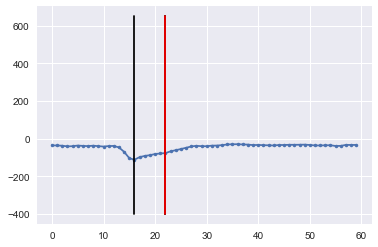

In [78]:

'''
3 categories: 1) if there's no max peak (max value <50) or 
                    
                    the first max before min is <50 and the first max after min is >50
                    
              2) if there's a max value (max > 50) but no min value (min>-50). 
              
              3) if both peaks before and after min are >50, and the peak after min is bigger than the peak before min.
              
              4) normal up-down-up plot
'''

#Category 1:
if (max_value<50) or (correct_chan[:min_peak_time].max()[0]<50 and correct_chan[min_peak_time:].max()[0]>50):
    baseline_for_down_up = baseline_algo_for_down_up(y=correct_chan['y_values'], lag=5, threshold=3.5, influence=0.5)
    baseline_value_for_down_up= correct_chan.loc[baseline_for_down_up][0]
    return_point_for_down_up = find_return_point_for_down_up(min_peak_time, from_min_to_end, correct_chan)
    data_table = pd.DataFrame({'Base to min (ms)':(min_peak_time-baseline_for_down_up)/30,
                               'Base to max (ms)': np.nan,
                               'Return to base (ms)': (return_point_for_down_up-baseline_for_down_up)/30, 
                               'Amplitude base-min (V)': min_value - baseline_value_for_down_up,
                               'Amplitude base-max (V)': np.nan,
                               'Amplitude min-max (V)': np.nan,
                              'spike_category': 'down_up'},
                              index=[0])
    
    plot_waveform_for_down_up(fig_to_save, baseline_for_down_up, correct_chan, baseline_value_for_down_up, return_point_for_down_up)

    
#Category 2:
elif (max_value)>50 and (min_value>-100):
    
    baseline = baseline_algo(y=correct_chan['y_values'], lag=5, threshold=3.5, influence=0.3)
    baseline_value = correct_chan.loc[baseline][0]
    no_min_return_point = find_return_point_when_no_min(max_peak_time, counter_when_no_min, correct_chan)
    data_table = pd.DataFrame({'Base to min (ms)': np.nan,
                               'Base to max (ms)':(max_peak_time-baseline)/30, 
                               'Return to base (ms)': (no_min_return_point-baseline)/30, 
                               'Amplitude base-min (V)': np.nan,
                               'Amplitude base-max (V)':max_value - baseline_value, 
                               'Amplitude min-max (V)': np.nan,
                              'spike_category': 'just_up'}, index=[0])
    
    plot_waveform_when_no_min(fig_to_save, baseline, correct_chan, baseline_value, no_min_return_point)

#Category 3:    
elif (correct_chan[:min_peak_time].max()[0])>50 and (correct_chan[min_peak_time:].max()[0]>50) and (correct_chan[:min_peak_time].max()[0]<correct_chan[min_peak_time:].max()[0]):
    special_baseline = baseline_algo(y=correct_chan['y_values'], lag=5, threshold=3.5, influence=0.3)
    special_baseline_value = correct_chan.loc[special_baseline][0]
    special_return_point = find_special_return_point(small_peak_time, from_min_to_end, correct_chan)
    data_table = pd.DataFrame({'Base to min (ms)':(min_peak_time-special_baseline)/30, 
                               'Base to max (ms)': np.nan,
                               'Return to base (ms)': (special_return_point-special_baseline)/30, 
                               'Amplitude base-min (V)': min_value - special_baseline_value,
                               'Amplitude base-max (V)': small_peak_value - special_baseline_value,
                               'Amplitude min-max (V)':small_peak_value + np.absolute(min_value),
                              'spike_category': 'up_down_up'},
                              index=[0])
    plot_special_waveform(fig_to_save, special_baseline, correct_chan, special_baseline_value, special_return_point)

#Category 4:  
else:

    baseline = baseline_algo(y=correct_chan['y_values'], lag=5, threshold=3.5, influence=0.3)
    baseline_value = correct_chan.loc[baseline][0]
    return_point = find_return_point(min_peak_time, from_min_to_end, correct_chan)
    data_table = pd.DataFrame({'Base to max (ms)':(max_peak_time-baseline)/30, 
                               'Base to min (ms)':(min_peak_time-baseline)/30, 
                               'Return to base (ms)':(return_point-baseline)/30, 
                               'Amplitude base-max (V)':max_value - baseline_value, 
                               'Amplitude min-max (V)':max_value + np.absolute(min_value),
                              'spike_category': 'up_down_up'}, index=[0])
    
    plot_waveform(fig_to_save, correct_chan, baseline, min_peak_time, baseline_value, return_point)
    
data_table
    

In [ ]:
correct_chan['y_values'][17]

In [ ]:
correct_chan['y_values'][16]

In [ ]:
correct_chan['y_values'][15]

In [ ]:
find_baseline(max_peak_time, from_start_to_max, correct_chan)

In [ ]:
correct_chan['y_values'].plot()

In [85]:
baseline_algo_for_down_up(y=correct_chan['y_values'], lag=5, threshold=3.5, influence=0.5)

12